# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';') 

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';') 

In [4]:
# Check the statistics of the general demographics data.
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.AGER_TYP.value_counts(dropna=False)

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [6]:
# Check the number of rows and columns in the general demographics data
azdias.shape

(891221, 85)

In [7]:
# Check the first five rows of the general demographics data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
# Check the first five rows in the feature summary file
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
# Check the information of rows and columns in the feature summary file
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Get the naturally missing null values
original_missing = azdias.isnull().sum()
original_missing.sum()

4896838

In [11]:
# Check the first five rows of the feature summary file
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [12]:
# Set the attribute column of the feature summary file as index
feat_info.set_index('attribute',inplace=True)
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [13]:
# Check the value of a missing_or_unknown of a particular row in the feature summary file
feat_info.loc['AGER_TYP','missing_or_unknown']

'[-1,0]'

In [14]:
# So even the missing_or_unknown values look like a list, it is saved as a string
# Convert these values as a list of strings or symbols
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[').str.strip(']').str.split(',')
feat_info.loc['AGER_TYP','missing_or_unknown']

['-1', '0']

In [15]:
# Convert the blank and 'XX' symbols in the missing_or_unknown values list into -1
col_names=feat_info.index
for col_name in col_names:
    if feat_info.loc[col_name,'missing_or_unknown'][0]=='':
        feat_info.loc[col_name,'missing_or_unknown'][0]='-1'
    if feat_info.loc[col_name,'missing_or_unknown'][0]=='XX':
        feat_info.loc[col_name,'missing_or_unknown'][0]='-1' 

In [16]:
# There is one binary variable (OST_WEST_KZ) that takes on non-numeric values. 
# So re-encode the values as numbers
ost_west_dict = {'OST_WEST_KZ': {'W':0, 'O':1}}
azdias = azdias.replace(ost_west_dict)

In [17]:
# There is one multi-lavel categorical variable (CAMEO_DEU_2015) that takes on non-numeric values. 
# So re-encode the values as numbers
cameo_deu_dict = {'CAMEO_DEU_2015': {'1A':0, '1B':1,'1C':2,'1D':3,'1E':4,'2A':5,'2B':6,'2C':7,'2D':8,'3A':9,'3B':10,'3C':11,'3D':12,'4A':13,'4B':14,'4C':15,'4D':16,'4E':17,'5A':18,'5B':19,'5C':20,'5D':21, \
                                    '5E':22,'5F':23,'6A':24,'6B':25,'6C':26,'6D':27,'6E':28,'6F':29,'7A':30,'7B':31,'7C':32,'7D':33,'7E':34,'8A':35,'8B':36,'8C':37,'8D':38,'9A':39,'9B':40,'9C':41,'9D':42,'9E':43,'XX':-1}}
azdias = azdias.replace(cameo_deu_dict)

In [18]:
# Convert all missing or unknown or naturally missing values to the first value of missing_or_unknown list
azdias=azdias.applymap(str)
for col_name in col_names:
    azdias[col_name].replace('nan', feat_info.loc[col_name,'missing_or_unknown'][0], inplace=True)
azdias['CAMEO_DEUG_2015'].replace('X', feat_info.loc[col_name,'missing_or_unknown'][0], inplace=True)

azdias['CAMEO_INTL_2015'].replace('XX', feat_info.loc[col_name,'missing_or_unknown'][0], inplace=True)

In [19]:
# Convert the float variable to integer
def convert_int(value):
    try:
        x=value.split(".",1)
        return int(x[0])
    except:
        return x

In [20]:
# Check the first five rows of the general demographics data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [21]:
# Convert the float values to integer
azdias=azdias.applymap(convert_int)

In [22]:
# Again check the first five rows of the general demographics data after the integer conversion
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2,3,4,3,5,5,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,1,2,5,1,5,2,5,4,5,...,2,3,2,1,1,5,4,3,5,4
2,-1,3,2,3,1,4,1,2,3,5,...,3,3,1,0,1,4,4,3,5,2
3,2,4,2,2,4,2,5,2,1,2,...,2,2,2,0,1,3,4,2,3,3
4,-1,3,1,5,4,3,4,1,3,2,...,2,4,2,1,2,3,3,4,6,5


In [23]:
# Convert all missing or unknown or naturally missing values to np.nan
azdias=azdias.applymap(str)
for col_name in col_names:
    azdias[col_name].replace(feat_info.loc[col_name].missing_or_unknown, np.nan, inplace=True)
    azdias[col_name].replace('nan', np.nan, inplace=True)

In [24]:
# Get the counts of all missing or unknown or naturally missing values
total_missing = azdias.isnull().sum()
total_missing.sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

In [25]:
# Get the total missing values
total_missing.sum()

8373929

In [26]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null object
ALTERSKATEGORIE_GROB     888340 non-null object
ANREDE_KZ                891221 non-null object
CJT_GESAMTTYP            886367 non-null object
FINANZ_MINIMALIST        891221 non-null object
FINANZ_SPARER            891221 non-null object
FINANZ_VORSORGER         891221 non-null object
FINANZ_ANLEGER           891221 non-null object
FINANZ_UNAUFFAELLIGER    891221 non-null object
FINANZ_HAUSBAUER         891221 non-null object
FINANZTYP                891221 non-null object
GEBURTSJAHR              498903 non-null object
GFK_URLAUBERTYP          886367 non-null object
GREEN_AVANTGARDE         891221 non-null object
HEALTH_TYP               780025 non-null object
LP_LEBENSPHASE_FEIN      793589 non-null object
LP_LEBENSPHASE_GROB      796649 non-null object
LP_FAMILIE_FEIN          813429 non-null object
LP_FAMILIE_GROB          

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [27]:
# Perform an assessment of how much missing data there is in each column of the dataset.
# Get the counts of all missing or unknown or naturally missing values
total_missing = azdias.isnull().sum()
total_missing.sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

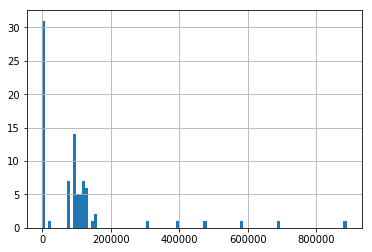

In [28]:
# Investigate patterns in the amount of missing data in each column.
total_missing.hist(bins=100)

In [29]:
# Outlier columns have more than 200000 missing values
missing_outliers=total_missing[total_missing > 200000].index
missing_outliers

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [30]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(missing_outliers, axis=1, inplace=True)
azdias.shape

(891221, 79)

In [31]:
# Check rows and columns of feature summary file
feat_info.shape

(85, 3)

In [32]:
# Drop the outlier index from feature summary file
feat_info_clean=feat_info.drop(missing_outliers,inplace=False)
feat_info_clean.shape

(79, 3)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are a total of 8373929 values missing in 891221 rows and 85 columns. There are 6 outlier columns which have more than  200000 observations missing. These columns are ```'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'```. So these columns are removed from the population dataset.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

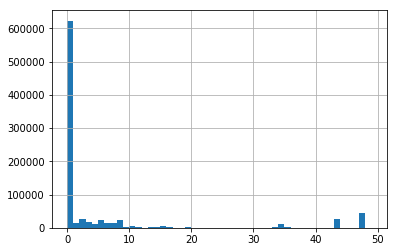

In [33]:
# How much data is missing in each row of the dataset?
missing_rows = azdias.isnull()
missing_rows.sum(axis=1).hist(bins=49)

In [34]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias['COMPLETE'] = azdias.isnull().sum(axis=1) == 0
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,COMPLETE
0,2,1,2,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1,2,5,1,5,2,5,4,5,1,...,3,2,1,1,5,4,3,5,4,True
2,3,2,3,1,4,1,2,3,5,1,...,3,1,0,1,4,4,3,5,2,True
3,4,2,2,4,2,5,2,1,2,6,...,2,2,0,1,3,4,2,3,3,False
4,3,1,5,4,3,4,1,3,2,5,...,4,2,1,2,3,3,4,6,5,True


In [35]:
# function for comparison countplots for a column
def facetplot_complete(col):
    sns.catplot(x=col, col="COMPLETE",data=azdias, kind="count",height=4, aspect=.7);

In [36]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_missing_columns=total_missing[total_missing==0].index
no_missing_columns

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

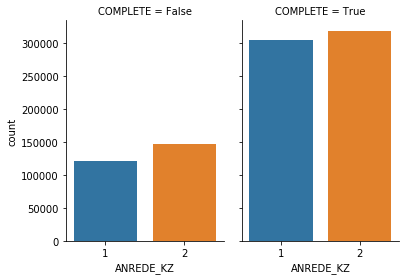

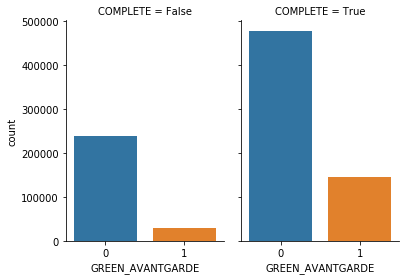

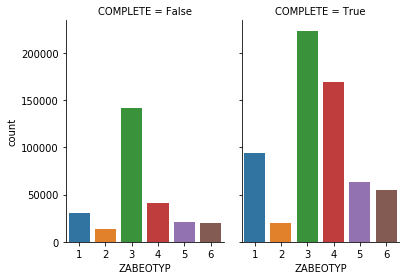

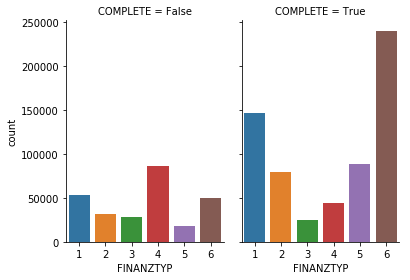

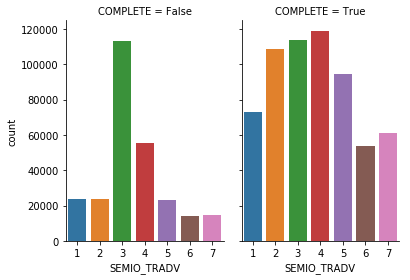

In [37]:
# Choose five columns for comparison between two subsets of observations
plot_columns=pd.Index(['ANREDE_KZ','GREEN_AVANTGARDE','ZABEOTYP','FINANZTYP','SEMIO_TRADV'])

for col in plot_columns:
    facetplot_complete(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

We divided the observations into two subsets: one for data points with no missing values, and a second subset for points with missing values. We have found that, the distributions of three non-missing features (```'ANREDE_KZ','GREEN_AVANTGARDE','ZABEOTYP'```) look similar between the data with many missing values and the data with no missing values. But for other non-missing features the distributions look different. So we are not going to drop any rows from the observations at this point.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
# How many features are there of each data type?
feat_info_clean.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
azdias['CJT_GESAMTTYP'].value_counts(dropna=True)

4    210963
3    156449
6    153915
2    148795
5    117376
1     98869
Name: CJT_GESAMTTYP, dtype: int64

In [40]:
# Assess categorical variables: which are binary, which are multi-level
cat_columns=feat_info_clean[feat_info_clean['type'] == 'categorical'].index
binary_cat = []
multi_cat = []
for column in cat_columns:
    if azdias[column].nunique(dropna=True) > 2:
        multi_cat.append(column)
    else:
        binary_cat.append(column)


In [41]:
# Check binary categorical features
binary_cat

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [42]:
# Check the different values of the binary variables
# 'OST_WEST_KZ' is encoded to numerical values in the earlier pre-processing step
for c in binary_cat:
    print(azdias[c].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0    810834
1      6888
Name: SOHO_KZ, dtype: int64
2    398722
1    381303
Name: VERS_TYP, dtype: int64
0    629528
1    168545
Name: OST_WEST_KZ, dtype: int64


In [43]:
# Check the multi-level categorical features
multi_cat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [45]:
# Some of the multi-level categorical variables are encoded by dummy variables
keep_cat=['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP']

In [46]:
# separte the columns
azdias_keep_cat=azdias[keep_cat]

In [47]:
# Impute the missing values by the median values
imputer = SimpleImputer(strategy='median')
imputed_features = imputer.fit_transform(azdias_keep_cat)

In [48]:
# Create a dataframe with the imputed values
azdias_keep_cat=pd.DataFrame(imputed_features,columns=keep_cat)

In [49]:
# Convert to string
azdias_dummy=azdias_keep_cat.astype(str)

In [50]:
# Create dummy variables for the multi-level variables
azdias_dummy=pd.get_dummies(azdias_dummy, columns=keep_cat)

In [51]:
azdias_dummy.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
0,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [52]:
azdias_dummy.shape

(891221, 29)

In [53]:
# Concate the old and new dataframes
azdias=pd.concat([azdias,azdias_dummy],axis=1)

In [54]:
azdias.shape

(891221, 109)

In [55]:
# Drop the multi-level categorical variables
azdias.drop(multi_cat, axis=1, inplace=True)
azdias.shape

(891221, 96)

In [ ]:
feat_info.shape

In [56]:
# Drop the index from the summary features
feat_info_clean.drop(multi_cat,inplace=True)
feat_info_clean.shape

(66, 3)

In [57]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 96 columns):
ALTERSKATEGORIE_GROB     888340 non-null object
ANREDE_KZ                891221 non-null object
FINANZ_MINIMALIST        891221 non-null object
FINANZ_SPARER            891221 non-null object
FINANZ_VORSORGER         891221 non-null object
FINANZ_ANLEGER           891221 non-null object
FINANZ_UNAUFFAELLIGER    891221 non-null object
FINANZ_HAUSBAUER         891221 non-null object
GREEN_AVANTGARDE         891221 non-null object
HEALTH_TYP               780025 non-null object
LP_LEBENSPHASE_FEIN      793589 non-null object
LP_LEBENSPHASE_GROB      796649 non-null object
PRAEGENDE_JUGENDJAHRE    783057 non-null object
RETOURTYP_BK_S           886367 non-null object
SEMIO_SOZ                891221 non-null object
SEMIO_FAM                891221 non-null object
SEMIO_REL                891221 non-null object
SEMIO_MAT                891221 non-null object
SEMIO_VERT               

#### Discussion 1.2.1: Re-Encode Categorical Features

We have decided to keep six multi-level categorical features such as ```'CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP'```. We chose to encode the values using multiple dummy variables. Before we encode them, we have imputed the missing values of these features by their respective median values. the other multi-level catteforical features ``` 'FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'GEBAEUDETYP',
 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'``` are not encoded and simply dropped because they have more than eight levels and some of them are captured by other features in the dataset.
 
 ```'OST_WEST_KZ'``` binary variable takes on non-numeric values. So it is encoded to numeric values 0 and 1 in an earlier pre-processing step 1.1.1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [58]:
mixed_columns=feat_info_clean[feat_info_clean['type'] == 'mixed'].index
mixed_columns

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'],
      dtype='object', name='attribute')

In [59]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias.PRAEGENDE_JUGENDJAHRE.value_counts(dropna=False)

14     188697
8      145988
NaN    108164
5       86416
10      85808
3       55195
15      42547
11      35752
9       33570
6       25652
12      24446
1       21282
4       20451
2        7479
13       5764
7        4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [60]:
# Map generation 
generation_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

def map_generation(x):
    try:
        for key, array in generation_dict.items():
            if int(x) in array:
                return int(key)
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_movement(x):
    try:
        if int(x) in mainstream:
            return int(0)
        else:
            return int(1)
    except ValueError:
        return np.nan

In [61]:
# Create generation column
azdias['PRAEGENDE_JUGENDJAHRE_GENERATION'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(map_generation)

# Create movement column
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [62]:
# Check value count of the new feature
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts(dropna=False)

0.0    607832
1.0    175225
NaN    108164
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

In [63]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias.CAMEO_INTL_2015.value_counts(dropna=False)

51     133694
NaN     99352
41      92336
24      91158
14      62884
43      56672
54      45391
25      39628
22      33155
23      26750
13      26336
45      26132
55      23955
52      20542
31      19024
34      18524
15      16974
44      14820
12      13249
35      10356
32      10354
33       9935
Name: CAMEO_INTL_2015, dtype: int64

###  CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [64]:
def map_wealth(x):
    try:
        w=int(x)//10
        return w
    except ValueError:
        return np.nan
    
def map_stage(x):
    try:
        s=int(x)%10
        return s
    except ValueError:
        return np.nan

In [65]:
# Create wealth  and life stage columns
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(map_wealth)

azdias['CAMEO_INTL_2015_STAGE'] = azdias['CAMEO_INTL_2015'].apply(map_stage)

In [66]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias.WOHNLAGE.value_counts(dropna=False)

3      249719
7      169318
4      135973
2      100376
NaN     93148
5       74346
1       43918
8       17473
0        6950
Name: WOHNLAGE, dtype: int64

###  WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

level 1,2,3,4,5 looks like an ordinal varible, level 7 and 8 are replaced by nan as the rural information is captured by ```BALLRAUM``` variable

In [67]:
neighborhood = [1, 2, 3, 4, 5]

def map_neighborhood(x):
    try:
        if int(x) in neighborhood:
            return int(x)
        else:
            return np.nan
    except ValueError:
        return np.nan

In [68]:
# Create neighborhood column
azdias['WOHNLAGE_NEIGHBORHOOD'] = azdias['WOHNLAGE'].apply(map_neighborhood)

In [69]:
# Check value counts of old feature
azdias['WOHNLAGE'].value_counts(dropna=False)

3      249719
7      169318
4      135973
2      100376
NaN     93148
5       74346
1       43918
8       17473
0        6950
Name: WOHNLAGE, dtype: int64

In [70]:
# check value counts of new engineered features
azdias['WOHNLAGE_NEIGHBORHOOD'].value_counts(dropna=False)

NaN    286889
3.0    249719
4.0    135973
2.0    100376
5.0     74346
1.0     43918
Name: WOHNLAGE_NEIGHBORHOOD, dtype: int64

In [71]:
# Drop the mixed variables
azdias.drop(mixed_columns, axis=1, inplace=True)
azdias.shape

(891221, 95)

In [72]:
# Drop index from feature summary
feat_info_clean.drop(mixed_columns,inplace=True)
feat_info_clean.shape

(60, 3)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Out of the six mixed variables ```'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE','WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'``` we have engineered three features ```'PRAEGENDE_JUGENDJAHRE','WOHNLAGE', 'CAMEO_INTL_2015'```. 
*```"PRAEGENDE_JUGENDJAHRE"``` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement. *```"CAMEO_INTL_2015"``` combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values). *```'WOHNLAGE' ``` combines neighborhood and rural levels. The rural levels are replaced by nan and other levels are used as an ordinal variable. The remaining mised varibales are dropped because they are captured by other features.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [73]:
# Drop the boolean feature
azdias.drop(['COMPLETE'],axis=1,inplace=True)

In [74]:
# Check that columns have the right type
azdias.describe()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,...,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,PRAEGENDE_JUGENDJAHRE_GENERATION,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE,WOHNLAGE_NEIGHBORHOOD
count,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,783057.000000,783057.00000,791869.000000,791869.000000,604332.000000
mean,0.110937,0.166956,0.175545,0.242159,0.131702,0.172701,0.565708,0.117036,0.032743,0.059227,...,0.037219,0.409444,0.235738,0.095325,0.083563,3.332805,0.22377,3.262098,2.873033,3.159603
std,0.314054,0.372937,0.380432,0.428390,0.338167,0.377989,0.495664,0.321463,0.177963,0.236048,...,0.189297,0.491731,0.424460,0.293664,0.276731,1.459284,0.41677,1.464494,1.484771,1.071632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.00000,2.000000,1.000000,3.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,4.000000,3.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.00000,5.000000,4.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.00000,5.000000,5.000000,5.000000


In [75]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 94 columns):
ALTERSKATEGORIE_GROB                888340 non-null object
ANREDE_KZ                           891221 non-null object
FINANZ_MINIMALIST                   891221 non-null object
FINANZ_SPARER                       891221 non-null object
FINANZ_VORSORGER                    891221 non-null object
FINANZ_ANLEGER                      891221 non-null object
FINANZ_UNAUFFAELLIGER               891221 non-null object
FINANZ_HAUSBAUER                    891221 non-null object
GREEN_AVANTGARDE                    891221 non-null object
HEALTH_TYP                          780025 non-null object
RETOURTYP_BK_S                      886367 non-null object
SEMIO_SOZ                           891221 non-null object
SEMIO_FAM                           891221 non-null object
SEMIO_REL                           891221 non-null object
SEMIO_MAT                           891221 non-null object
SEMI

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [76]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    ost_west_dict = {'OST_WEST_KZ': {'W':0, 'O':1}}
    df = df.replace(ost_west_dict)
    cameo_deu_dict = {'CAMEO_DEU_2015': {'1A':0, '1B':1,'1C':2,'1D':3,'1E':4,'2A':5,'2B':6,'2C':7,'2D':8,'3A':9,'3B':10,'3C':11,'3D':12,'4A':13,'4B':14,'4C':15,'4D':16,'4E':17,'5A':18,'5B':19,'5C':20,'5D':21, \
                                        '5E':22,'5F':23,'6A':24,'6B':25,'6C':26,'6D':27,'6E':28,'6F':29,'7A':30,'7B':31,'7C':32,'7D':33,'7E':34,'8A':35,'8B':36,'8C':37,'8D':38,'9A':39,'9B':40,'9C':41,'9D':42,'9E':43,'XX':-1}}
    df = df.replace(cameo_deu_dict)
    df = df.applymap(str)
    col_names=df.columns
    for col_name in col_names:
        df[col_name].replace('nan', feat_info.loc[col_name,'missing_or_unknown'][0], inplace=True)
    df['CAMEO_DEUG_2015'].replace('X', feat_info.loc[col_name,'missing_or_unknown'][0], inplace=True)

    df['CAMEO_INTL_2015'].replace('XX', feat_info.loc[col_name,'missing_or_unknown'][0], inplace=True)
    df=df.applymap(convert_int)
    df=df.applymap(str)
    for col_name in col_names:
        df[col_name].replace(feat_info.loc[col_name].missing_or_unknown, np.nan, inplace=True)
        df[col_name].replace('nan', np.nan, inplace=True)
    
    
    # remove selected columns and rows, ...
    df.drop(missing_outliers, axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    df_keep_cat=df[keep_cat]
    imputer = SimpleImputer(strategy='median')
    imputed_features = imputer.fit_transform(df_keep_cat)
    df_keep_cat=pd.DataFrame(imputed_features,columns=keep_cat)
    df_dummy=df_keep_cat.astype(str)
    df_dummy=pd.get_dummies(df_dummy, columns=keep_cat)
    df=pd.concat([df,df_dummy],axis=1)
    df.drop(multi_cat, axis=1, inplace=True)
    df['PRAEGENDE_JUGENDJAHRE_GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_generation)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(map_wealth)
    df['CAMEO_INTL_2015_STAGE'] = df['CAMEO_INTL_2015'].apply(map_stage)
    df['WOHNLAGE_NEIGHBORHOOD'] = df['WOHNLAGE'].apply(map_neighborhood)
    
    # Return the cleaned dataframe.
    df.drop(mixed_columns, axis=1, inplace=True)
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [77]:
# Column names
col_names=azdias.columns

In [78]:
# Copy the dataset
features = azdias.copy()

# Impute nans
imputer = SimpleImputer(strategy='median')
imputed_features = imputer.fit_transform(features)

In [79]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
standardized_features = scaler.fit_transform(imputed_features)

In [80]:
imputed_features

array([[2., 1., 3., ..., 4., 3., 3.],
       [1., 2., 1., ..., 5., 1., 4.],
       [3., 2., 1., ..., 2., 4., 2.],
       ...,
       [2., 2., 2., ..., 2., 4., 3.],
       [1., 1., 1., ..., 5., 1., 5.],
       [4., 1., 4., ..., 4., 3., 4.]])

### Discussion 2.1: Apply Feature Scaling

We have replaced the missing values by imputing them with the median value of the column. For the actual scaling function, a StandardScaler instance is used, scaling each feature to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [81]:
# Apply PCA to the data.
pca = PCA(0.9)
pca_features = pca.fit_transform(standardized_features)

In [82]:
# Investigate the variance accounted for by each principal component.
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


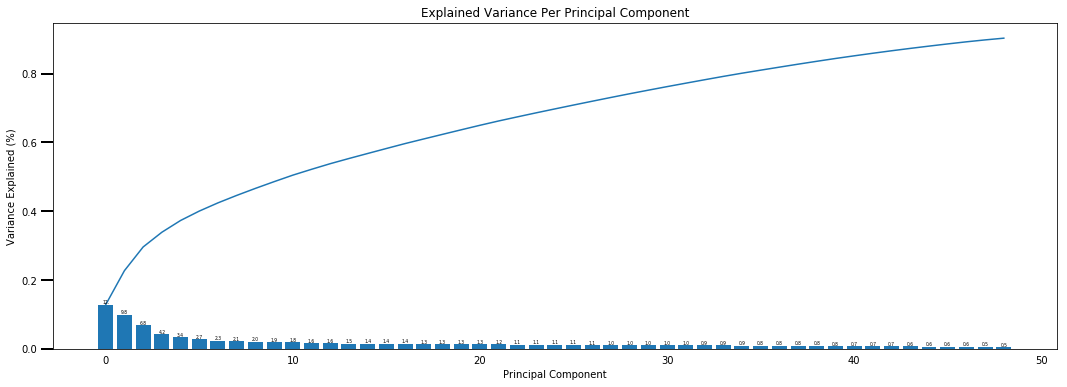

In [83]:
scree_plot(pca)

In [84]:
num_components=len(pca.explained_variance_ratio_)
num_components

49

### Discussion 2.2: Perform Dimensionality Reduction

We have reduced the dimension of features from 94 to 49 by using PCA. 90% of the variace is conserved in this dimensionality reduction step.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [85]:
# Implement collection of results based off Udacity defined function
def pca_results(full_dataset, pca):
    # Create dimensions index
    dimensions = ['Dimension {}'.format(i) for i \
                  in range(1, len(pca.components_) + 1)]
    
    # Capture pca components
    pca_comp = pca.components_
    
    # Create components df
    components_df = pd.DataFrame(np.round(pca_comp, 4), 
                              columns= full_dataset.columns)
    components_df.index = dimensions
    
    # Create PCA variance explained df
    ratios = pca.explained_variance_ratio_.reshape(len(pca_comp), 1)
    ratios_df = pd.DataFrame(np.round(ratios, 4), 
                             columns=['Explained Variance'])
    ratios_df.index = dimensions
    
    # Return combined df
    return pd.merge(ratios_df, components_df, left_index=True, right_index=True)

In [86]:
results=pca_results(azdias,pca)
results.head(5)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,PRAEGENDE_JUGENDJAHRE_GENERATION,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE,WOHNLAGE_NEIGHBORHOOD
Dimension 1,0.1283,-0.1092,0.0179,-0.2134,0.1418,-0.1089,0.0766,0.0747,0.1542,-0.1164,...,-0.0525,-0.0141,0.0427,0.0862,0.0383,0.0926,-0.1164,0.1957,-0.1173,0.0883
Dimension 2,0.0989,0.2442,0.0673,0.0661,-0.2265,0.2276,-0.1921,-0.2064,0.1151,-0.0160,...,-0.0380,0.1976,-0.0995,-0.0917,0.0202,-0.2459,-0.0160,0.0688,0.0007,0.0159
Dimension 3,0.0689,0.0482,-0.3209,0.1123,-0.0934,0.0708,-0.1910,-0.1195,-0.0270,0.0649,...,-0.0219,-0.0722,-0.0306,-0.0107,0.0619,-0.0514,0.0649,0.0173,-0.0240,0.0233
Dimension 4,0.0428,-0.0250,0.0915,0.0128,-0.0069,-0.0228,-0.0952,0.0174,-0.0514,0.3444,...,0.1197,-0.1116,0.0231,-0.0134,-0.0300,0.0560,0.3444,-0.0812,0.0333,-0.0993
Dimension 5,0.0342,0.0381,0.1170,-0.0643,-0.0391,-0.0212,-0.0167,-0.1654,0.0310,-0.1206,...,0.0245,-0.1712,0.2142,0.0249,-0.0111,0.0848,-0.1206,0.0053,-0.0384,0.1076


In [87]:
# Implement plot of results
def plot_pca_dim(results_df, pca, dimension_name, figsize=(14, 8)):
    # Collect dimension info
    dimension = results_df.loc[dimension_name].sort_values(ascending=False)
    positive = dimension[dimension >=0].head(10)
    negative = dimension[dimension <0].tail(10)
    
    # Create bar plot
    plt.figure(figsize=figsize)
    plt.subplot(211)
    positive.plot(kind='bar')
    plt.axhline(y=0.15, ls='--', c='#b3b3b3', lw=1)
    #plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplot(212)
    negative.plot(kind='bar')
    plt.axhline(y=-0.15, ls='--', c='#b3b3b3', lw=1);
    #plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplots_adjust(bottom=0.8)
    plt.suptitle("{}: {}% Variance Explained".format(
        dimension_name, 
        np.round(results_df.loc[dimension_name, 'Explained Variance']*100, 2)),
                 fontsize=18)
    plt.tight_layout()

In [88]:
# Implement print-out of higher weighted features
def weighted_features(results, dimension_name):
    print("High Positive\n", 
      results.loc[dimension_name][results.loc[dimension_name] >= 0.15].sort_values(ascending=False))
    print("\nHigh Negative\n", 
      results.loc[dimension_name][results.loc[dimension_name] <= -0.15].sort_values())

High Positive
 PLZ8_ANTG3                0.2071
LP_STATUS_GROB_1.0        0.2015
PLZ8_ANTG4                0.2009
CAMEO_INTL_2015_WEALTH    0.1957
ORTSGR_KLS9               0.1768
EWDICHTE                  0.1767
HH_EINKOMMEN_SCORE        0.1702
FINANZ_HAUSBAUER          0.1542
Name: Dimension 1, dtype: float64

High Negative
 MOBI_REGIO          -0.2268
FINANZ_MINIMALIST   -0.2134
KBA05_ANTG1         -0.2110
PLZ8_ANTG1          -0.2074
KBA05_GBZ           -0.2027
PLZ8_GBZ            -0.1535
KONSUMNAEHE         -0.1516
Name: Dimension 1, dtype: float64


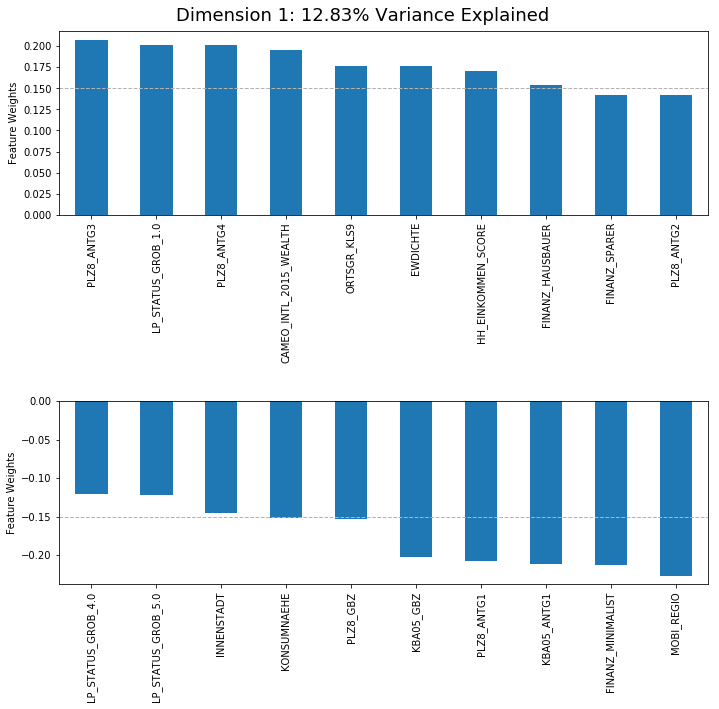

In [89]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca, 'Dimension 1', figsize=(10, 10))
weighted_features(results, 'Dimension 1')

High Positive
 ALTERSKATEGORIE_GROB    0.2442
FINANZ_VORSORGER        0.2276
SEMIO_ERL               0.2086
ZABEOTYP_3.0            0.1976
SEMIO_LUST              0.1739
RETOURTYP_BK_S          0.1610
Name: Dimension 2, dtype: float64

High Negative
 PRAEGENDE_JUGENDJAHRE_GENERATION   -0.2459
FINANZ_SPARER                      -0.2265
SEMIO_TRADV                        -0.2230
SEMIO_REL                          -0.2223
SEMIO_PFLICHT                      -0.2180
FINANZ_UNAUFFAELLIGER              -0.2064
FINANZ_ANLEGER                     -0.1921
SEMIO_KULT                         -0.1901
ONLINE_AFFINITAET                  -0.1707
SEMIO_RAT                          -0.1704
SEMIO_FAM                          -0.1616
SEMIO_MAT                          -0.1500
Name: Dimension 2, dtype: float64


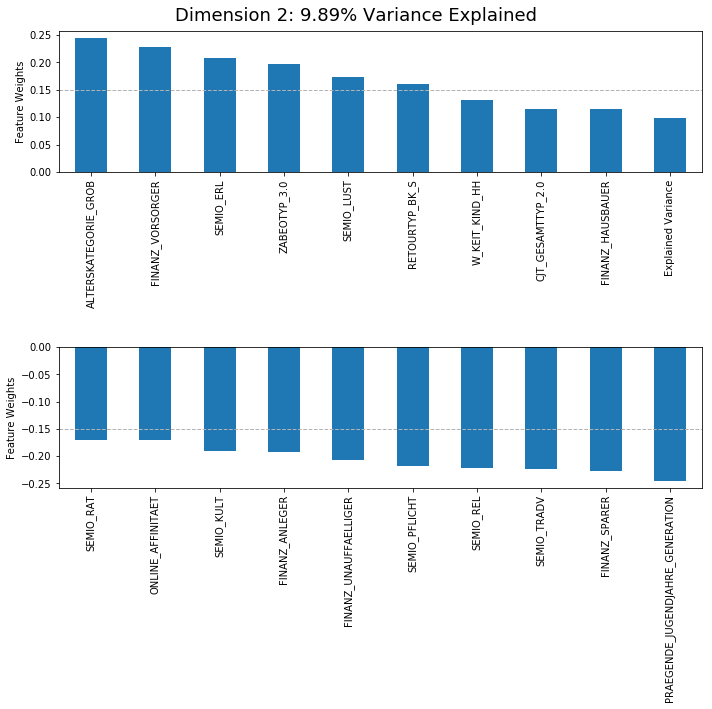

In [90]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca, 'Dimension 2', figsize=(10, 10))
weighted_features(results, 'Dimension 2')

High Positive
 SEMIO_VERT    0.3352
SEMIO_SOZ     0.2788
SEMIO_KULT    0.2524
SEMIO_FAM     0.1947
Name: Dimension 3, dtype: float64

High Negative
 SEMIO_KAEM        -0.3270
ANREDE_KZ         -0.3209
SEMIO_DOM         -0.3043
SEMIO_KRIT        -0.2930
FINANZ_ANLEGER    -0.1910
SEMIO_RAT         -0.1682
SHOPPER_TYP_2.0   -0.1610
Name: Dimension 3, dtype: float64


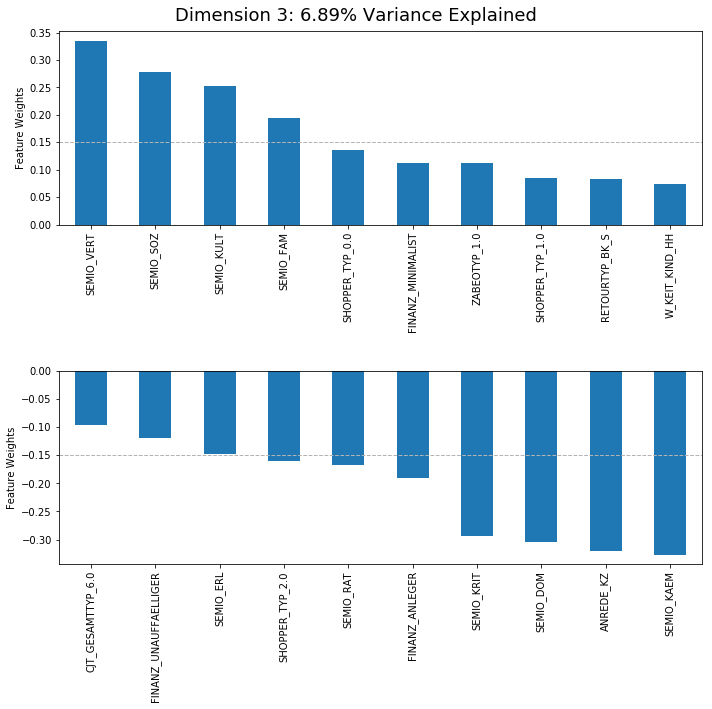

In [91]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca, 'Dimension 3', figsize=(10, 10))
weighted_features(results, 'Dimension 3')

### Discussion 2.3: Interpret Principal Components

* Principal Component 1
    * High Positives
        * PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region, high share)               
        * LP_STATUS_GROB_1.0 (Social status, rough scale, low income earner)       
        * PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region, high share)           
        * CAMEO_INTL_2015_WEALTH (Wealth Typology, poorer household)
        * ORTSGR_KLS9 (Size of community)
        * EWDICHTE (Density of households per square kilometer, high density)
        * HH_EINKOMMEN_SCORE (Estimated household net income, very low)
        * FINANZ_HAUSBAUER (Home ownership, very low)
    * High Negatives
        * MOBI_REGIO (Movement patterns, Very high movement)      
        * FINANZ_MINIMALIST (low financial interest, very high)   
        * KBA05_ANTG1 (Number of 1-2 family houses in the microcell, lower share)       
        * PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region, lower share)       
        * KBA05_GBZ (Number of buildings in the microcell, less buildings)
        * KONSUMNAEHE (Distance from building to point of sale, close)

This component seems to describe people, who are relatively poor, living in high density buildings/neighborhoods/community , moving a lot. They are not likely to be interested in saving. They don't own a house.

* Principal Component 2
    * High Positives
        * ALTERSKATEGORIE_GROB (Estimated age based on given name analysis, older)    
        * FINANZ_VORSORGER (be prepared, low)       
        * SEMIO_ERL (personality event oriented, low)               
        * ZABEOTYP_3.0 (Energy consumption typology, fair supplied)           
        * SEMIO_LUST (Personality sensual-minded, lowest)             
        * RETOURTYP_BK_S (Return type, determined)
    * High Negatives
        * PRAEGENDE_JUGENDJAHRE_GENERATION (generation, old)  
        * FINANZ_SPARER (money-saver, very high)                   
        * SEMIO_TRADV (Personality traditional, high)                        
        * SEMIO_REL (Personality religious, high)                     
        * SEMIO_PFLICHT (Personality dutiful, high)  
        
These are older people, more likely to be in their 60s/born in 1940s. They consider themselves to be traditional, religious and dutiful. They have a range of interests in money from money savers. They don't seem likely to make rash purchases.

* Principal Component 3
    * High Positives
        * SEMIO_VERT (Personality dreamful, lowest)    
        * SEMIO_SOZ  (Personality social-minded, lowest)   
        * SEMIO_KULT (Personality cultural-minded, lowest)
        * SEMIO_FAM  (Personality family-minded, lowest)   
    * High Negatives
        * SEMIO_KAEM (Personality combative-minded, highest)       
        * ANREDE_KZ  (Gender, Male)   
        * SEMIO_DOM  (Personality dominant-minded, highest)       
        * SEMIO_KRIT (Personality critical-minded, highest)      
        * FINANZ_ANLEGER (Investor financial typology, high)
        * SEMIO_RAT (Personality rational, highest)      
        * SHOPPER_TYP_2.0 (Shopper typology family-shopper, lowest)
        
These are men with combative, dominant, critical-minded, rational personality with practical thinking, anti-social, anti0cultural and anti-family attitude. They are interested in money, particularly around investing.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

--- Run time: 6.35 mins ---


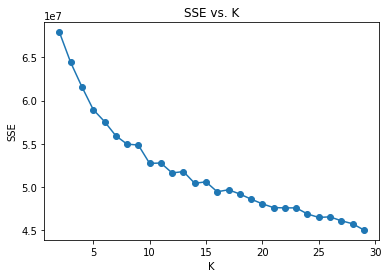

In [92]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
start_time = time.time()

sse = []
k_range = np.arange(2, 30)

for k in k_range:
    kmeans = MiniBatchKMeans(k,batch_size=100000, max_iter=1000).fit(pca_features)
    sse.append(np.abs(kmeans.score(pca_features)))
    kmeans_labels = kmeans.predict(pca_features)
    
plt.plot(k_range, sse, linestyle='-', marker='o');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

In [93]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start_time = time.time()
kmeans = MiniBatchKMeans(5,batch_size=100000, max_iter=1000).fit(pca_features)
kmeans_labels = kmeans.predict(pca_features)

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 0.11 mins ---


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [94]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [95]:
# Check first five rows of customer dataset
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [96]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
features_customers  = clean_data(customers)

In [97]:
# Check the difference between the columns of the two dataset
list(set(azdias.columns) - set(features_customers.columns))

[]

In [98]:
# Use the sklearn objects from the general demographics data, 
# and apply their transformations to the customers data. 
imputed_customers = imputer.transform(features_customers)

standardized_customers = scaler.transform(imputed_customers)

pca_customers = pca.transform(standardized_customers)

kmeans_customers = kmeans.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [99]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Proportions for general data
dict_data = {'proportion': pd.Series(kmeans_labels).value_counts(normalize=True, sort=False), 
          'source': 'general'}

general_proportions = pd.DataFrame(dict_data)

# Proportions for customer data
dict_data = {'proportion': pd.Series(kmeans_customers).value_counts(normalize=True, sort=False), 
          'source': 'customer'}

customer_proportions = pd.DataFrame(dict_data)

# Concatenate proportions
total_proportions = pd.concat([general_proportions, customer_proportions])


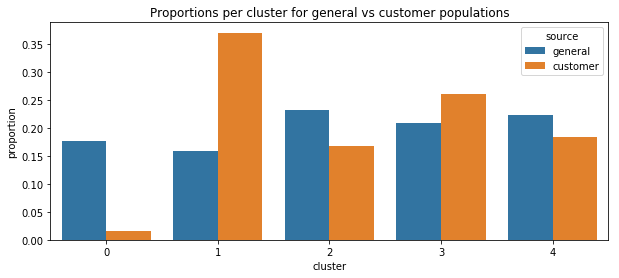

In [100]:
# Compare the proportions per cluster for general vs customer populations
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(ax=ax, x=total_proportions.index, y = total_proportions.proportion, hue=total_proportions.source)
ax.set_xlabel('cluster')
ax.set_title('Proportions per cluster for general vs customer populations');

In [101]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
diff_customer_proportions = customer_proportions['proportion'] - general_proportions['proportion']
diff_customer_proportions.sort_values(ascending=False, inplace=True)
print('over-represented')
print(diff_customer_proportions[:2])


over-represented
1    0.212558
3    0.051650
Name: proportion, dtype: float64


In [102]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print('\nunder-represented')
print(diff_customer_proportions[-2:])



under-represented
2   -0.064154
0   -0.161563
Name: proportion, dtype: float64


In [104]:
# Let's look at cluster 1, it's over represented for customers
def compare_cluster_demographics(k):
    pca_cluster = pca_features[kmeans_labels == k]
    print('cluster', k, 'accounts for', np.round(pca_cluster.shape[0]*100/pca_features.shape[0],3), '% of general population')
    standardized_features = pca.inverse_transform(pca_cluster)
    features_cluster1 = scaler.inverse_transform(standardized_features)
    features_cluster1 = pd.DataFrame(np.round(features_cluster1), columns = azdias.columns)
    features_cluster1['POPULATION']='general'
    
    pca_cluster = pca_customers[kmeans_customers == k]
    print('cluster', k, 'accounts for', np.round(pca_cluster.shape[0]*100/pca_customers.shape[0],3), '% of customer population')
    standardized_features = pca.inverse_transform(pca_cluster)
    features_cluster2 = scaler.inverse_transform(standardized_features)
    features_cluster2 = pd.DataFrame(np.round(features_cluster2), columns = azdias.columns)
    features_cluster2['POPULATION']='customer'
    
    features_cluster=pd.concat([features_cluster1,features_cluster2],axis=0)
    
    columns=['PLZ8_ANTG3','MOBI_REGIO','ALTERSKATEGORIE_GROB','PRAEGENDE_JUGENDJAHRE_GENERATION','SEMIO_VERT','ANREDE_KZ']
    
    for col in columns:
        sns.catplot(x=col, col="POPULATION",data=features_cluster, kind="count",height=4, aspect=.7);


cluster 1 accounts for 15.806 % of general population
cluster 1 accounts for 37.062 % of customer population


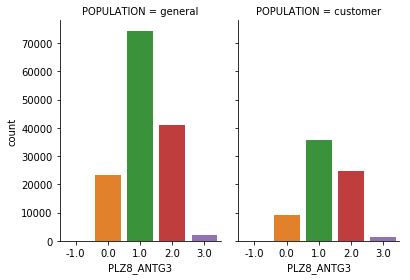

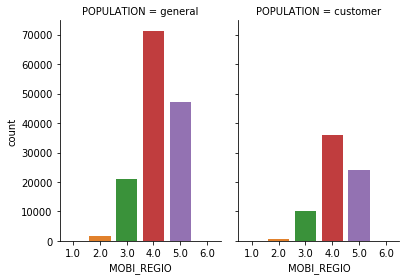

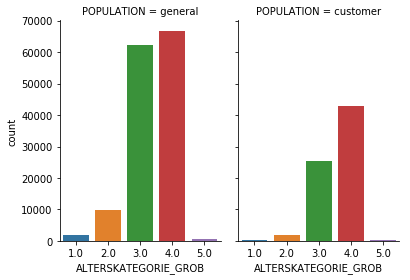

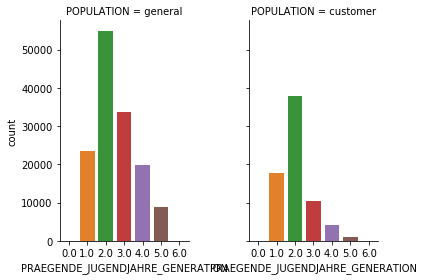

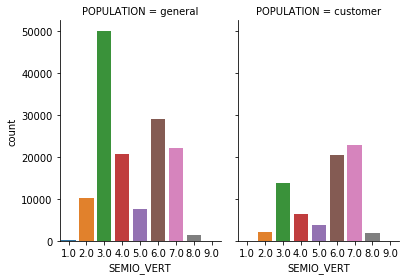

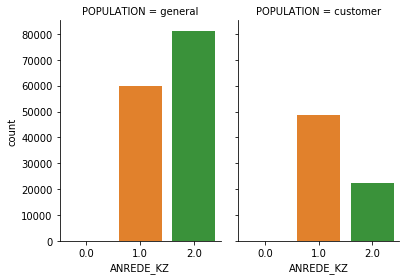

In [105]:
compare_cluster_demographics(1)

cluster 0 accounts for 17.669 % of general population
cluster 0 accounts for 1.513 % of customer population


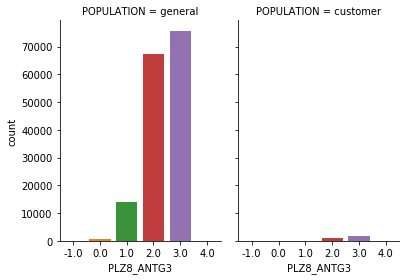

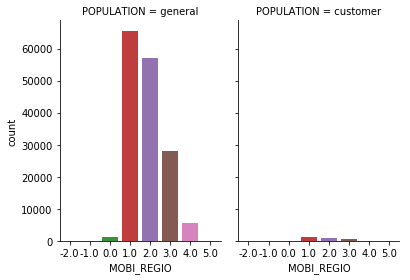

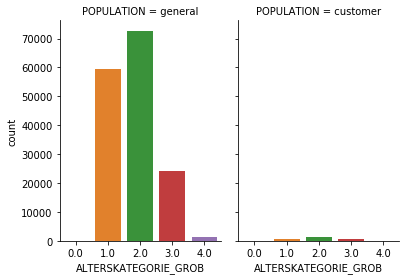

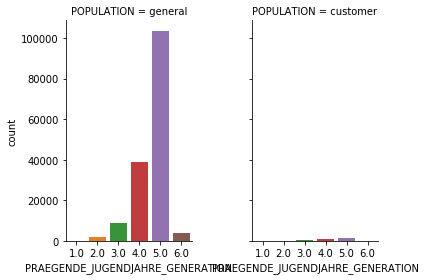

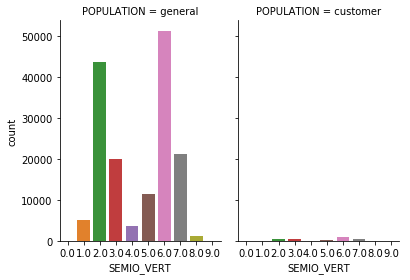

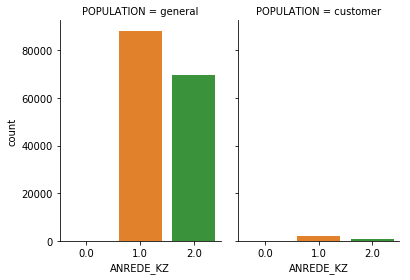

In [106]:
compare_cluster_demographics(0)

### Discussion 3.3: Compare Customer Data to Demographics Data

Clusters 1 and 3 are over-represented and clusters 0, 2 and 4 are under-represented in the customer dataset.

Cluster 1 accounts 37% in the customer population and 15.8% in the general population. From our analysis, it is clear that this segment of population are mostly older people, more likely to be in their 60s/born in 1940s. Since they are more interesed to the mail-order shopping, we should target this segment of population.

Cluster 0 accounts 1.5% in the customer population and 17.7% in the general population. From our analysis, it is clear that this segment of population are living in high-density regions and they have high moving patterns. Since this segment is relatively unpopular with the mail-order company, so we need to find ways to attract this segment of population.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.